In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mplsoccer import VerticalPitch
import numpy as np

In [12]:
event_df = pd.read_csv('data/events.csv')
passes = event_df[(event_df['event'] == 'pass') & (event_df['half_time'] == 1)]
line_breaking_passes = passes[passes['line_break_outcome'] == 'line_break_complete']
zone3_passes = line_breaking_passes[((line_breaking_passes['side'] == 'l' ) & (line_breaking_passes['x_location_end'] > 0.67))
| ((line_breaking_passes['side'] == 'r' ) & (line_breaking_passes['x_location_end'] < 0.33))]
print(len(zone3_passes))


20


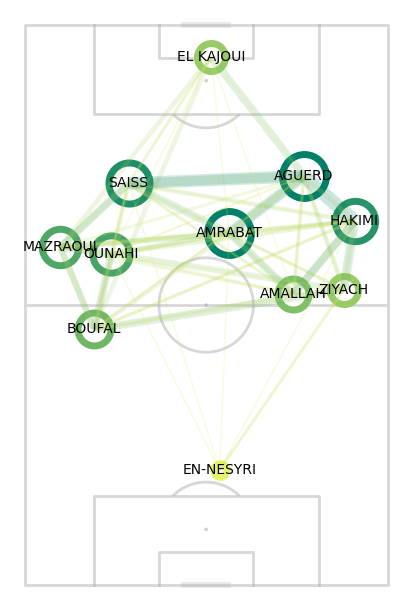

In [13]:
TEAM = 1

event_df = pd.read_csv('data/events.csv')
lineup_df = pd.read_csv('data/lineup.csv', encoding='utf-8')

teams = lineup_df['team_id'].unique()
passes_df = event_df[(event_df['team_id'] == teams[TEAM]) & (
    event_df['event'] == 'pass') & (event_df['outcome'] == 'possession_complete')]

sub_times = event_df[(event_df['event'] == 'substitution_on')
                    & (event_df['team_id'] == teams[TEAM])]['match_time_in_ms'].values
passes_df = passes_df[passes_df['match_time_in_ms'] < sub_times.min()]   

passes_df.loc[passes_df['half_time'] % 2 == 0, 'x'] = 1 - \
    passes_df.loc[passes_df['half_time'] % 2 == 0, 'x']
passes_df.loc[passes_df['half_time'] % 2 == 0, 'y'] = 1 - \
    passes_df.loc[passes_df['half_time'] % 2 == 0, 'y']

median_loc = passes_df.groupby(
    'from_player_id').agg({'x': ['median'], 'y': ['median'], 'match_time_in_ms': ['count']})
median_loc.columns = ['x', 'y', 'count']
median_loc['x'] = median_loc['x']*100
median_loc['y'] = median_loc['y']*100

passes_between = passes_df.groupby(
    ['from_player_id', 'to_player_id']).size().reset_index(name='count')

pitch = VerticalPitch(line_alpha=0.5, goal_alpha=0.3, pitch_type='wyscout')
fig, ax = pitch.draw(figsize=(8,6.2))

merge_median_loc_lineup = pd.merge(median_loc, lineup_df,
    left_on='from_player_id', right_on='player_id')
median_loc = median_loc.rename(
    columns={'x': 'x_from', 'y': 'y_from'})
merged_df = pd.merge(
    passes_between, median_loc, on='from_player_id', suffixes=('', '_from')
)
median_loc = median_loc.rename(
    columns={'x_from': 'x_end', 'y_from': 'y_end'})
merged_df = pd.merge(
    merged_df, median_loc, left_on='to_player_id', right_on='from_player_id', suffixes=('', '_end')
)
max_passes_player = median_loc['count'].max()
max_passes_pair = merged_df['count'].max()

# setup colormaps
from matplotlib import colors
from matplotlib import cm as cmx
jet = cm = plt.get_cmap('summer_r') #summer
cNormPl  = colors.Normalize(vmin=0, vmax=max_passes_player)
scalarMapPl = cmx.ScalarMappable(norm=cNormPl, cmap=jet)
cNormPa  = colors.Normalize(vmin=0, vmax=max_passes_pair)
scalarMapPa = cmx.ScalarMappable(norm=cNormPa, cmap=jet)

# plot edges
import unicodedata
for _, row in merged_df.iterrows():

    player1_x = row['x_from']
    player1_y = row['y_from']

    player2_x = row['x_end']
    player2_y = row['y_end']

    num_passes = row["count"]
    line_width = (num_passes/max_passes_pair) * 10.0
    edge_color = scalarMapPa.to_rgba(num_passes)

    pitch.lines(player1_x, player1_y, player2_x, player2_y, 
        color=edge_color, ax=ax, alpha_end=0.1, alpha_start=0.1, 
        transparent=True, lw=line_width
        )

# plot nodes
for id, row in median_loc.iterrows():
    count = row['count']
    name = lineup_df[lineup_df['player_id'] == id]['player_last_name'].values[0]
    
    name = name.replace('&#262;', 'Ć')
    name = name.replace('&#268;', 'Č')
    name = name.replace('&#352;', 'Š')
    node_color = scalarMapPl.to_rgba(count)
    size = (count/max_passes_player) * 1000.0

    x = row['x_end']
    y = row['y_end']

    pitch.scatter(x, y, s=size, 
        edgecolors=node_color, linewidth=5,facecolor='white', alpha=1, ax=ax)

    pitch.annotate(name, [x,y], xytext=None, ax=ax, ha='center', va='center')

fig.savefig('morocco passing network')


***WORLD RANKING:***

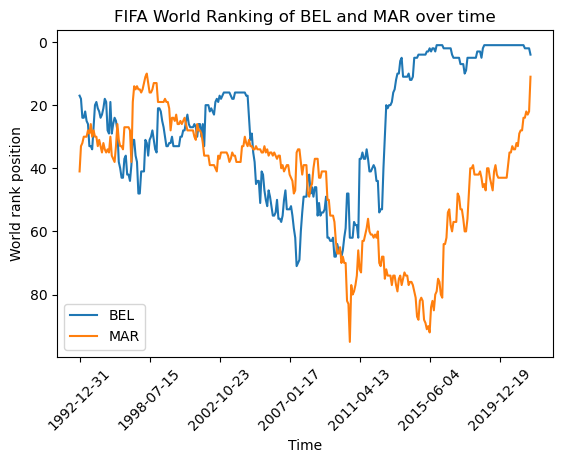

In [4]:
team1 = 'BEL'
team2 = 'MAR'

df = pd.read_csv('data/fifa_ranking-2022-12-22.csv')

rank_over_time1 = df[df['country_abrv'] == team1][['rank', 'rank_date']]
rank_over_time2 = df[df['country_abrv'] == team2][['rank', 'rank_date']]

ax = rank_over_time1.plot(x = 'rank_date', y = 'rank', label=team1)
rank_over_time2.plot(ax = ax, x = 'rank_date', y = 'rank', label=team2)

plt.ylabel('World rank position')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.title('FIFA World Ranking of %s and %s over time' % (team1, team2))
plt.subplots_adjust(bottom = 0.2)

plt.savefig('rankings_over_time.svg')


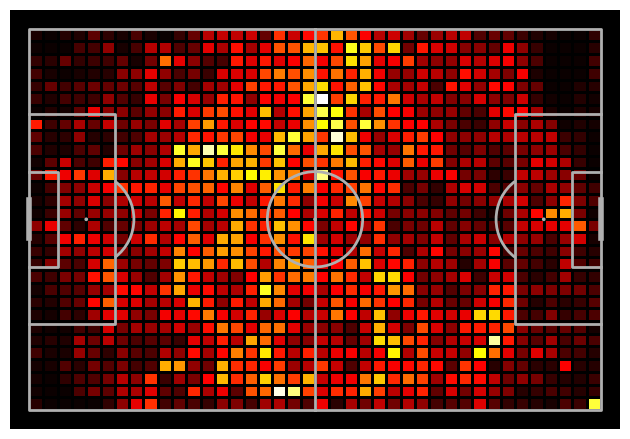

In [15]:
from mplsoccer import Pitch
tracking_df = pd.read_csv('data/tracking.csv')
# Assumption: the tracking data is in tracking_df as shown in the preprocess notebook

# stores x and y coordinate of ball (team -1) without counting breaks (while alive)
x = tracking_df[(tracking_df.team_id==-1) & (tracking_df.state=="Alive") ].x
y = tracking_df[(tracking_df.team_id==-1) & (tracking_df.state=="Alive") ].y

# rescale to fit coordinates used by mplsoccer
x = (x + 5250) * (120 / 2 / 5250)
y = (y + 3400) * (80 / 2 / 3400)

#draw pitch
pitch = Pitch(line_zorder=2, pitch_color='black')
fig, ax = pitch.draw()

# draw heatmap
stats = pitch.bin_statistic(x, y, bins=(40, 30))
pitch.heatmap(stats, edgecolors='black', cmap='hot', ax=ax)


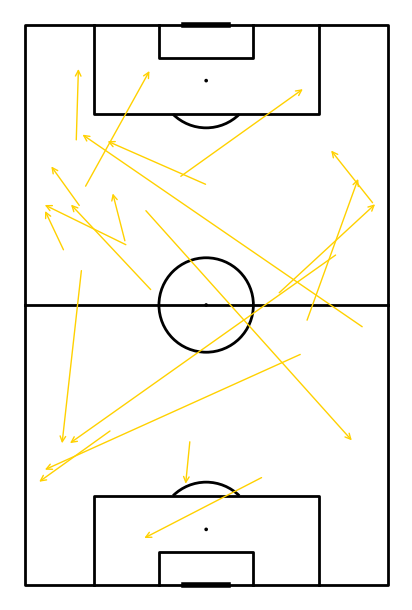

In [16]:
def transform_coords(coords):
    y = coords[0] * 100
    x = (1 - coords[1]) * 100
    return x, y

# draw pitch
pitch = VerticalPitch(pitch_color='w', line_color='k', pitch_type='wyscout')
fig, ax = pitch.draw(figsize=(8, 6.2))

for _, lb_pass in zone3_passes.iterrows():
    # transform coordinates
    pass_start_x, pass_start_y = transform_coords([lb_pass['x_location_start'], lb_pass['y_location_start']])
    pass_end_x, pass_end_y = transform_coords([lb_pass['x_location_end'], lb_pass['y_location_end']])
    # draw the pass
    ax.annotate("", xy=(pass_end_x, pass_end_y), xytext=(pass_start_x, pass_start_y), arrowprops=dict(arrowstyle="->", color=("#8A1538" if lb_pass['team_id'] == 43834 else "#FFD100")))
plt.show()

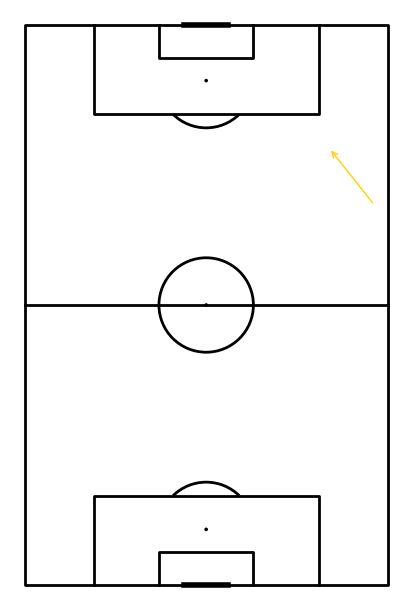

In [17]:
def transform_tracking_coords(coords):
    y = (coords[0] + 5250) / (2*5250) * 100
    x = (1 - (coords[1] + 3400) / (2*3400)) * 100
    return x, y


# draw pitch
pitch = VerticalPitch(pitch_color='w', line_color='k', pitch_type='wyscout')
fig, ax = pitch.draw(figsize=(8, 6.2))

big_pass = zone3_passes.iloc[6]

tracking_df = pd.read_csv('data/tracking.csv')
frame_id = 1713295 + int(big_pass['match_run_time_in_ms']/1000*25)

tracking_frame = tracking_df[tracking_df['frame'] == frame_id]


# transform coordinates
pass_start_x, pass_start_y = transform_coords([big_pass['x_location_start'], big_pass['y_location_start']])
pass_end_x, pass_end_y = transform_coords([big_pass['x_location_end'], big_pass['y_location_end']])
# draw the pass
ax.annotate("", xy=(pass_end_x, pass_end_y), xytext=(pass_start_x, pass_start_y), arrowprops=dict(arrowstyle="->", color=("#8A1538" if big_pass['team_id'] == 43834 else "#FFD100")))

for _, entity in tracking_frame.iterrows():
    if entity['team_id'] == -1:
        # Draw ball
        circle = Ellipse((transform_tracking_coords([entity['x'], entity['y']])), 2*1.05, 2*0.68, color='white', ec='black')
    else:
        if entity['team_id'] == 43927:
            color = "#FFD100"
        else:
            color = "#8A1538"
        circle = Ellipse((transform_tracking_coords([entity['x'], entity['y']])), 4*1.05, 4*0.68, color=color, ec='black')
    ax.add_patch(circle)
        



In [18]:

# from datetime import date


# #from eventvideo.get_video import get_video
# from tqdm import tqdm

# def get_time(st):
#     st = st.split(':')
#     return float(st[2])*1000 + float(st[1])*1000*60 + float(st[0])*1000*3600


# # working with wyscout data

# df = pd.read_csv('wyscout/wyscout.csv')
# df2 = pd.read_csv('data/events.csv')
# df_lineup = pd.read_csv('data/lineup.csv')
# print(df.columns)
# df_shots = df[((df['type.primary']=='shot') | (df['type.primary']=='penalty'))&
#     (df['shot.onTarget'] == True)]

# h1 = df[df.matchPeriod=='1H'].tail(1).matchTimestamp.values[0]
# h2 = df[df.matchPeriod=='2H'].head(1)
# offset = (get_time(h1)-get_time('00:45:00'))/1000
# h3 = df.tail(1).matchTimestamp.values[0]

# # in seconds
# totalMatchTime = offset+get_time(h3)

# # might has to be adjusted
# fix = 20

# s_names = []
# s_time = []
# s_goal = []
# for i, row in tqdm(df_shots.iterrows(), total=df_shots.shape[0]):
#     name = row['player.name']
#     time = get_time(row['matchTimestamp'])
#     penalty = row['type.primary'] == 'penalty'
#     goal = row['shot.isGoal']

#     # download the videos
#     # get_video(offset_2nd_half=offset+fix, match_id=row.matchId, match_time_in_ms=time, half=int(row.matchPeriod[0]), event_video_path="eventvideo/eventvideo.py")

#     if (row.matchPeriod=='2H'):
#         time += offset*1000

#     s_names.append(name)
#     s_time.append(time)
#     s_goal.append(goal)

# df_cards = df[df['infraction.yellowCard'] | df['infraction.redCard']] 

# c_names = []
# c_time = []
# for i, row in tqdm(df_cards.iterrows(), total=df_cards.shape[0]):
#     name = row['player.name']
#     time = get_time(row['matchTimestamp'])

#     # adjustment for one
#     if (i == 659):
#         time = time+10000

#     # download the videos
#     # get_video(offset_2nd_half=offset+fix, match_id=row.matchId, match_time_in_ms=time, half=int(row.matchPeriod[0]), event_video_path="eventvideo/eventvideo.py")
#     if (row.matchPeriod=='2H'):
#         time += offset*1000
    
#     c_names.append(name)
#     c_time.append(time)


# # working with fifa data

# print(df2.columns)


# su_in = []
# su_out = []
# su_time = []

# df_subs = df2[df2['event'] =='substitution_on']
# import html
# for _, row in tqdm(df_subs.iterrows(), total=df_subs.shape[0]):
#     player_out = df_lineup[df_lineup.player_id == row.from_player_id]['player_last_name'].values[0]
#     player_in = df_lineup[df_lineup.player_id == row.to_player_id]['player_last_name'].values[0]
#     # fixes some unicode trouble
#     player_out = html.unescape(player_out)
#     player_in = html.unescape(player_in)

#     time = get_time(row.match_run_time)
#     if (row.half_time==2):
#         time -= 15*60*1000

#     su_in.append(player_in)
#     su_out.append(player_out)
#     su_time.append(time)


# # plot the timeline

# # verticle lines
# l = len(su_time) + len(s_time) + len(c_time)
# levels = np.tile([-5, 5, -3, 3, -1, 1],
#                  int(np.ceil(l/6)))[:l]

# sorted_time = [i for i in sorted(su_time + s_time + c_time)]
# print(sorted_time)

# fig, ax = plt.subplots(figsize=(8.8*2, 4*2), layout="constrained")
# ax.set(title="Summary")

# ax.vlines(sorted_time, 0, levels, color="tab:red")  # The vertical stems.
# TIMES = [i for i in sorted(sorted_time + [0] + [totalMatchTime])]
# ax.plot(TIMES, np.zeros_like(TIMES), "-o",
#         color="k", markerfacecolor="w")  # Baseline and markers on it.
# # dots for beginning, half and end
# ax.scatter(get_time(h1),0,s=200, color="black")
# ax.scatter(totalMatchTime,0,s=200, color="black")
# ax.scatter(0,0,s=200, color="black")

# # annotate lines
# past_t = 0
# for t in sorted_time:
#     # it was a shot
#     if (t in s_time):
#         i = s_time.index(t)
#         if (s_goal[i]):
#             s = f'{s_names[i]} shot a goal!!!'
#         else:
#             s = f'{s_names[i]} shot onto the goal...'
#     elif (t in c_time):
#         i = c_time.index(t)
#         # if there was a red card you prbl have to adjust here
#         s = f'{c_names[i]} got a yellow card.'
#     elif (t in su_time):
#         i = su_time.index(t)
#         if past_t == t:
#             i += 1
#         s = f'{su_out[i]} -> {su_in[i]}'
#     else:
#         s = ''
#     i = sorted_time.index(t)
#     if past_t == t:
#         i += 1
#     past_t = t
#     l = levels[i]
#     ax.annotate(s, xy=(t, l),
#                 xytext=(len(s)*2, np.sign(l)+25*np.sign(l)), textcoords="offset points",
#                 horizontalalignment="right",arrowprops=dict(facecolor='black', shrink=0.05),
#                 verticalalignment="bottom" if l > 0 else "top")


# import matplotlib.dates as md
# def format_func(value, tick_number):
#     m = value/1000/60 % 60
#     h = value/1000/3600 
#     return '%02d:%02d' %(h, m)
# ax.xaxis.set_major_locator(plt.MultipleLocator(1000*60*5))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# # remove y-axis and spines
# ax.yaxis.set_visible(False)
# ax.spines[["left", "top", "right"]].set_visible(False)

# plt.xlim([-1000*60*1, totalMatchTime + 1000*60*1])
# plt.ylim([-10, 10])

# plt.savefig('summary.png')
# #plt.show()


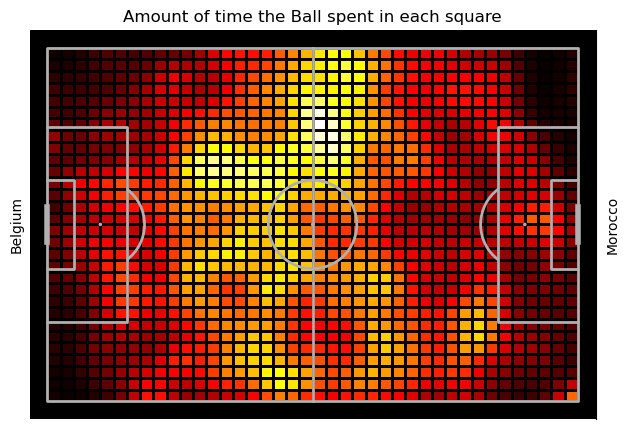

In [20]:
# Data: the traking data is stored in tracking_df as shown in the preprocess notebook

# general imports: numpy as np, pandas 
from mplsoccer import Pitch
from scipy.ndimage import gaussian_filter


# stores x and y coordinate of ball (team -1) without counting breaks (while alive)
alive_ball = tracking_df[(tracking_df.team_id==-1) & ((tracking_df.state=="Alive"))]
#reading out data of the right frames from both halves
ab1 = alive_ball[alive_ball.frame < 2060000] #20600000 is some frame during the break
ab2 = alive_ball[alive_ball.frame > 2060000]

# adding first and second half, accounting for the fact that teams change the sides
x = np.concatenate([ab1.x, -ab2.x])
y = np.concatenate([ab1.y, -ab2.y])
# rescale to fit coordinates used by mplsoccer
x = (x + 5250) * (120 / 2 / 5250)
y = (y + 3400) * (80 / 2 / 3400)

#draw pitch
pitch = Pitch(line_zorder=2, pitch_color='black')
fig, ax = pitch.draw()

#titles and labels
ax.set_title("Amount of time the Ball spent in each square")
ax.set_ylabel("Belgium")
secax_y = ax.secondary_yaxis('right')
secax_y.set_ticks([])
secax_y.set_ylabel("Morocco")

# draw heatmap
stats = pitch.bin_statistic(x, y, bins=(40, 30))
stats['statistic'] = gaussian_filter(stats['statistic'], 1)
pitch.heatmap(stats, edgecolors='black', cmap='hot', ax=ax)


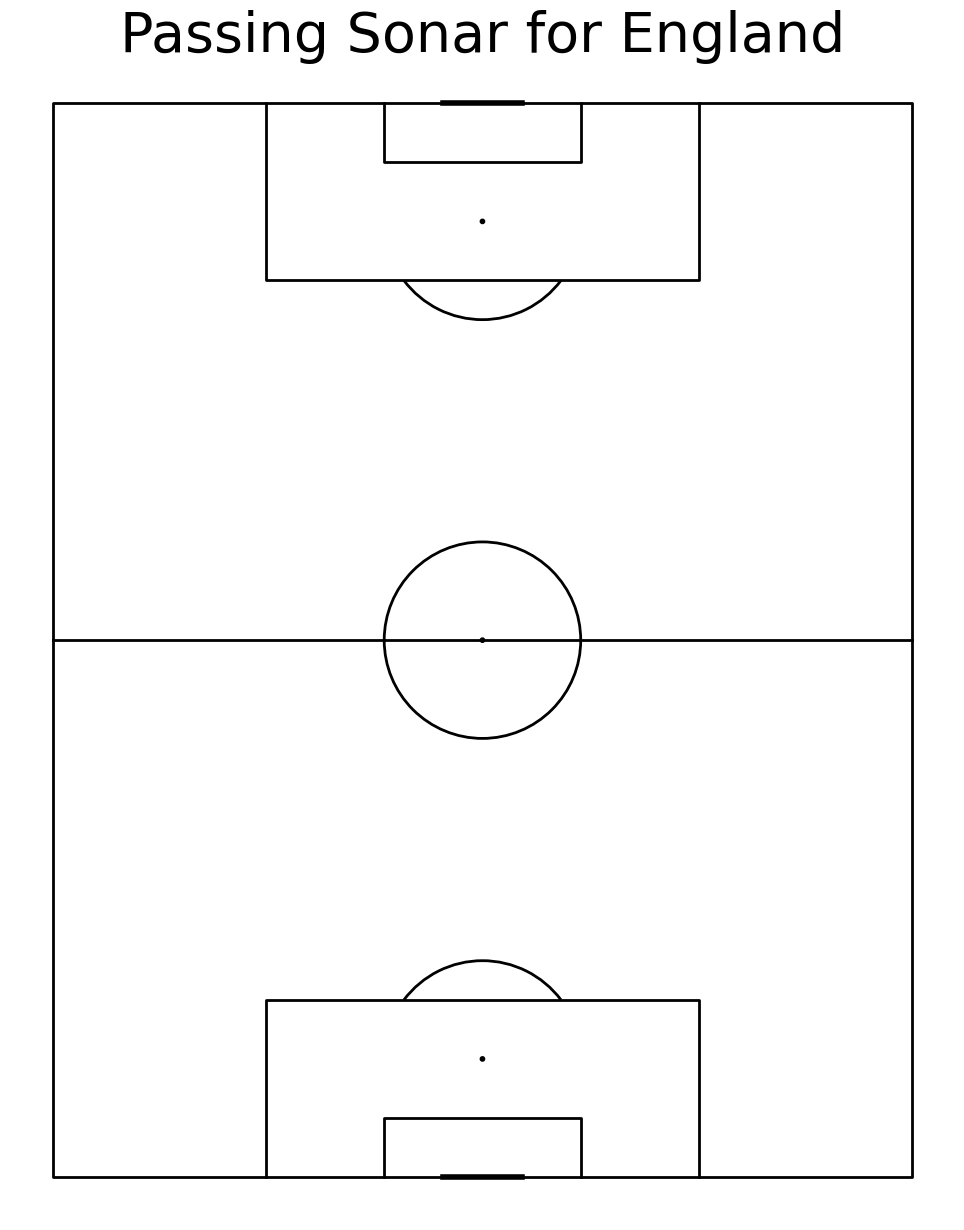

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from mplsoccer import VerticalPitch
import numpy as np
import math

#BASIC SETUP OF THINGS
team_id = 43935 #England == 43942, Senegal == 43879
team_name = 'England'
cmap_name = 'Blues' #https://matplotlib.org/stable/tutorials/colors/colormaps.html

#IMPORTANT, otherwise will be incorrectly mirrored
left_to_right = True #(in first half); lookup in playdirection.csv

circle_step = 24 #size of segments in circle in degrees
start_frame = 1980164 #only take players that were in the starting formation
lineup = {336022 : (0.42, 0), 356750 : (0.64, 0.19), 336450 : (0.20, 0.19), 433097 : (0.42, 0.45), 369434 : (0.53, 0.11), 407498 : (0.31, 0.11), 
          356189 : (0.57, 0.4), 369419 : (0.42, 0.7), 448196 : (0.62, 0.62), 405836 : (0.22, 0.62), 448202 : (0.27, 0.4), }

#Get metadata
players = pd.read_csv('data/lineup.csv')
players_team = players[(players['team_id'] == team_id) & (players['player_starting_frame'] == start_frame)].sort_values("player_jersey_number")
players_team

#make sonar
def transform_coords(coords, mirror=False):
    y = coords[0]
    x = (1 - coords[1]) #account for fifa coordiantes
    if mirror:
        x = 1 - x
        y = 1 - y
    return x, y

def vector(start_x, start_y, end_x, end_y):
    x = (end_x - start_x)
    y = (end_y - start_y)
    return x, y

pitch = VerticalPitch(pitch_color='w', line_color='k', pitch_type='custom', pitch_length=100, pitch_width=80)
fig, ax = pitch.draw(figsize=(16, 12.4))
ax.set_title("Passing Sonar for %s" % team_name, fontsize=40)

for i, player in players_team.iterrows():
    player_id = player['player_id']
    first_name = player['player_first_name']
    last_name = player['player_last_name']
    last_name = last_name.capitalize()

    #Read data
    event_df = pd.read_csv('data/events.csv')
    passes_h1 = event_df[(event_df['event'] == 'pass') & (event_df['half_time'] == 1) & (event_df['from_player_id'] == player_id)]
    passes_h2 = event_df[(event_df['event'] == 'pass') & (event_df['half_time'] == 2) & (event_df['from_player_id'] == player_id)]
    
    segment_count = [] #count of passes in each segment
    segment_avg = [] #average amplitude in each segment
    pass_count = 0
    angles = np.linspace(0, 2 * np.pi, 360 // circle_step, endpoint=False)
    for i in range(360 // circle_step):
        segment_count.append(0)
        segment_avg.append(0)

    def add_to_segment(x, y):
        angle = math.degrees(math.atan2(y, x))
        rounded = (math.floor(angle / circle_step) * circle_step)
        segment_no = rounded // circle_step
        norm = math.sqrt(x*x + y*y)
        segment_avg[segment_no] = (segment_avg[segment_no] * segment_count[segment_no] + norm) / (segment_count[segment_no] + 1)
        segment_count[segment_no] += 1

    for _, pass_h1 in passes_h1.iterrows():
        # transform coordinates
        pass_start_x, pass_start_y = transform_coords([pass_h1['x_location_start'], pass_h1['y_location_start']], mirror= not left_to_right)
        pass_end_x, pass_end_y = transform_coords([pass_h1['x_location_end'], pass_h1['y_location_end']], mirror= not left_to_right)
        #make into vector
        x, y = vector(pass_start_x, pass_start_y, pass_end_x, pass_end_y)
        #log data
        add_to_segment(x, y)
        pass_count += 1

    for _, pass_h2 in passes_h2.iterrows():
        # transform coordinates
        pass_start_x, pass_start_y = transform_coords([pass_h2['x_location_start'],  pass_h2['y_location_start']], mirror=left_to_right)
        pass_end_x, pass_end_y = transform_coords([pass_h2['x_location_end'],  pass_h2['y_location_end']], mirror=left_to_right)
        #make into vector
        x, y = vector(pass_start_x, pass_start_y, pass_end_x, pass_end_y)
        #log data
        add_to_segment(x, y)
        pass_count += 1

    #generate sonar
    left, bottom, width, height = lineup[player_id][0], lineup[player_id][1], 0.16, 0.16
    ay = fig.add_axes([left, bottom, width, height], projection='polar')
    count = np.array(segment_count)
    cmap = mpl.colormaps[cmap_name]
    normalised = (count - np.min(count)) / (np.max(count) - np.min(count))
    colour = cmap(normalised) 
    ay.bar(angles, segment_avg, width=(2 * np.pi / (360 // circle_step)), color=colour)
    #ax.xaxis.set_ticklabels(['', '', 'Opponent Goal', '', '', '', 'Own Goal'])
    ay.xaxis.set_ticklabels([])
    ay.yaxis.set_ticklabels([])
    ay.set_yticks(np.arange(np.min(segment_avg), np.max(segment_avg), 0.1))
    #ax.set_title('Passing Sonar for %s' % first_name + ' ' + last_name)
    ay.set_title('%s: %d' % (last_name, pass_count))
    
plt.savefig('sonar_%s.svg' % team_name.lower(), format='svg')
